In [116]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
sys.path.append('data_preprocessing')

import summary
import outliers
import normalize
import learning_helpers

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

# Get Data 

In [37]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_test.csv')

In [38]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.take_logs(train_data)
train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.take_logs(test_data)
test_data = normalize.normalize(test_data)

geo_train_data = normalize.fill_in_missing_values(geo_train_data)
geo_train_data = outliers.remove_outliers(geo_train_data)
#geo_train_data = normalize.take_logs(geo_train_data)
geo_train_data = normalize.normalize(geo_train_data)

geo_test_data = normalize.fill_in_missing_values(geo_test_data)
geo_test_data = outliers.remove_outliers(geo_test_data)
#geo_test_data = normalize.take_logs(geo_test_data)
geo_test_data = normalize.normalize(geo_test_data)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(train_data.loc[:, train_data.columns != 'log_SalePrice'], 
                                                  train_data['log_SalePrice'],
                                                  test_size=0.2, random_state=42)
X_test = train_data.drop('log_SalePrice', 1)
y_test = train_data['log_SalePrice']


# Split geodemo training set into train and validation set
X_geo_train, X_geo_val, y_geo_train, y_geo_val = train_test_split(geo_train_data.loc[:, geo_train_data.columns != 'log_SalePrice'], 
                                                                  geo_train_data['log_SalePrice'],
                                                                  test_size=0.2, random_state=42)
X_geo_test = geo_train_data.drop('log_SalePrice', 1)
y_geo_test = geo_train_data['log_SalePrice']

In [94]:
param_grid = {
        'n_estimators': [100, 120, 150, 170, 200],
        'learning_rate': [3, 3.25, 3.5, 3.75, 4]
    }
abr = AdaBoostRegressor()
gs = GridSearchCV(abr, param_grid = param_grid,
                   scoring='r2')
gs.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120, 150, 170, 200], 'learning_rate': [3, 3.25, 3.5, 3.75, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [109]:
print(gs.best_params_['learning_rate'])
print(gs.best_params_['n_estimators'])

abr = AdaBoostRegressor(learning_rate = gs.best_params_['learning_rate'], n_estimators = gs.best_params_['n_estimators'])
abr.fit(X_train, y_train)
y_pred = abr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

3.5
170
0.874347459293


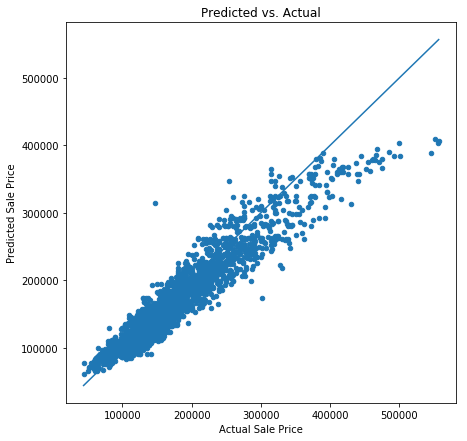

Final r2 score: 0.8742719234054515
Median margin of error: 0.09334661761044748


In [110]:
y_pred = abr.predict(X_test)
y_test_norm = np.exp(y_test)
y_pred_norm = np.exp(y_pred)
summary.pred_vs_actual_plot(y_pred_norm, y_test_norm)
print('Final r2 score: {0}'.format(r2_score(y_test_norm, y_pred_norm)))
median_margin_of_error = np.median(np.abs((y_pred_norm - y_test_norm) / y_test_norm))
print('Median margin of error: {0}'.format(median_margin_of_error))

In [127]:

br = BaggingRegressor()
gs = GridSearchCV(br, param_grid = param_grid, scoring='r2')
br.fit(X_train, y_train)


0.956359235977


# This did really well, huh?

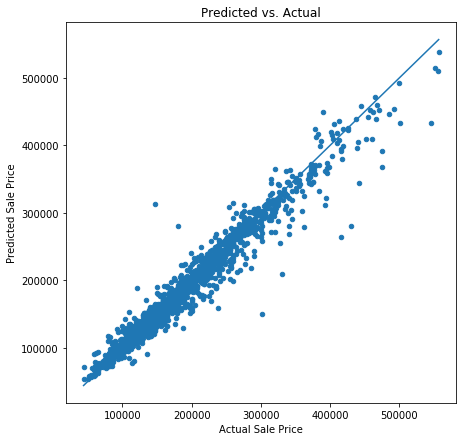

Final r2 score: 0.9552723118869839
Median margin of error: 0.0316508492877359


In [129]:
y_pred = br.predict(X_test)
y_test_norm = np.exp(y_test)
y_pred_norm = np.exp(y_pred)
summary.pred_vs_actual_plot(y_pred_norm, y_test_norm)
print('Final r2 score: {0}'.format(r2_score(y_test_norm, y_pred_norm)))
median_margin_of_error = np.median(np.abs((y_pred_norm - y_test_norm) / y_test_norm))
print('Median margin of error: {0}'.format(median_margin_of_error))